# Original Model

使用了正则化

清洗数据，去掉大gamma，线性标准化，激活函数用relu，dropout 0.2

In [1]:
import pandas as pd
import numpy as np
import pyttsx3

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
#from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
md_para = pd.read_csv('../data/substituted_benzene_para_md.csv',index_col=0,header=0)
md_orth = pd.read_csv('../data/substituted_benzene_orth_md.csv',index_col=0,header=0)
md_meta = pd.read_csv('../data/substituted_benzene_meta_md.csv',index_col=0,header=0)
mddata = pd.concat([md_meta,md_orth,md_para],axis=0,join='inner',ignore_index=True)

gammadata_meta = pd.read_csv('../data/substituted_benzene_meta_gamma.csv',index_col=0,header=0)
gammadata_orth = pd.read_csv('../data/substituted_benzene_orth_gamma.csv',index_col=0,header=0)
gammadata_para = pd.read_csv('../data/substituted_benzene_para_gamma.csv',index_col=0,header=0)
gammadata = pd.concat([gammadata_meta,gammadata_orth,gammadata_para],axis=0,join='inner',ignore_index=True)

In [3]:
def dfclean(data):
    temp = data[data.T[data.dtypes!=np.object].index]
    kk=[]
    for column in temp.columns:
        if len(set(temp[column]))<4:
            kk.append(column)
    result = temp.drop(columns=kk)
    return result

In [4]:
rawdataset = pd.merge(mddata, gammadata, on='cindex')
dataset = dfclean(rawdataset)

In [5]:
#dataset = dataset[(dataset['magnitude_gamma'] < 22088)]

In [6]:
#dataset = (dataset-dataset.min(axis=0))/(dataset.max(axis = 0)-dataset.min(axis=0))

In [7]:
Y = dataset.iloc[:, -1]
Y = np.array(Y, dtype = np.float32).reshape(-1,1)

normalizer = Normalization(axis=-1)
normalizer.adapt(Y)
Y = normalizer(Y)
Y = np.array(Y, dtype = np.float32).reshape(-1,1)

In [8]:
X = dataset.iloc[:, 1:-1]
X = np.array(X, dtype = np.float32)

normalizer = Normalization(axis=-1)
normalizer.adapt(X)
X = normalizer(X)
X = np.array(X, dtype = np.float32)
#Y= StandardScaler().fit_transform(Y)
#Y = (Y - min(Y))/(max(Y) - min(Y))
#Y = Y/max(Y)
#X= StandardScaler().fit_transform(X)

In [9]:
X.shape

(360, 945)

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)
model = Sequential()
model.add(Dense(units = 64, input_dim = X.shape[1]))
model.add(Dense(64, input_dim=64, activation='relu',
                kernel_regularizer=regularizers.l2(0.1),
                activity_regularizer=regularizers.l1(0.1)))
model.add(Activation("relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                60544     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 64,769
Trainable params: 64,769
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss = 'mean_absolute_error', optimizer = SGD(lr = 0.0001, momentum = 0.9, nesterov = True),metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 1000, batch_size = 10,validation_data = (X_test, y_test),verbose=0)
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred = model.predict(X_test)
rms = (np.mean((y_test - y_pred) ** 2)) ** 0.5
print("Neural Network RMS", rms)

Test loss: 0.5387572646141052
Test accuracy: 0.0
Neural Network RMS 0.745974506216136


In [12]:
from collections import Counter

In [13]:
a = abs(y_test-y_pred)/y_test < 0.05

In [14]:
i=0
for v in a:
    if v:
        i+=1
print(i)

56


In [15]:
i/len(y_test)

0.6222222222222222

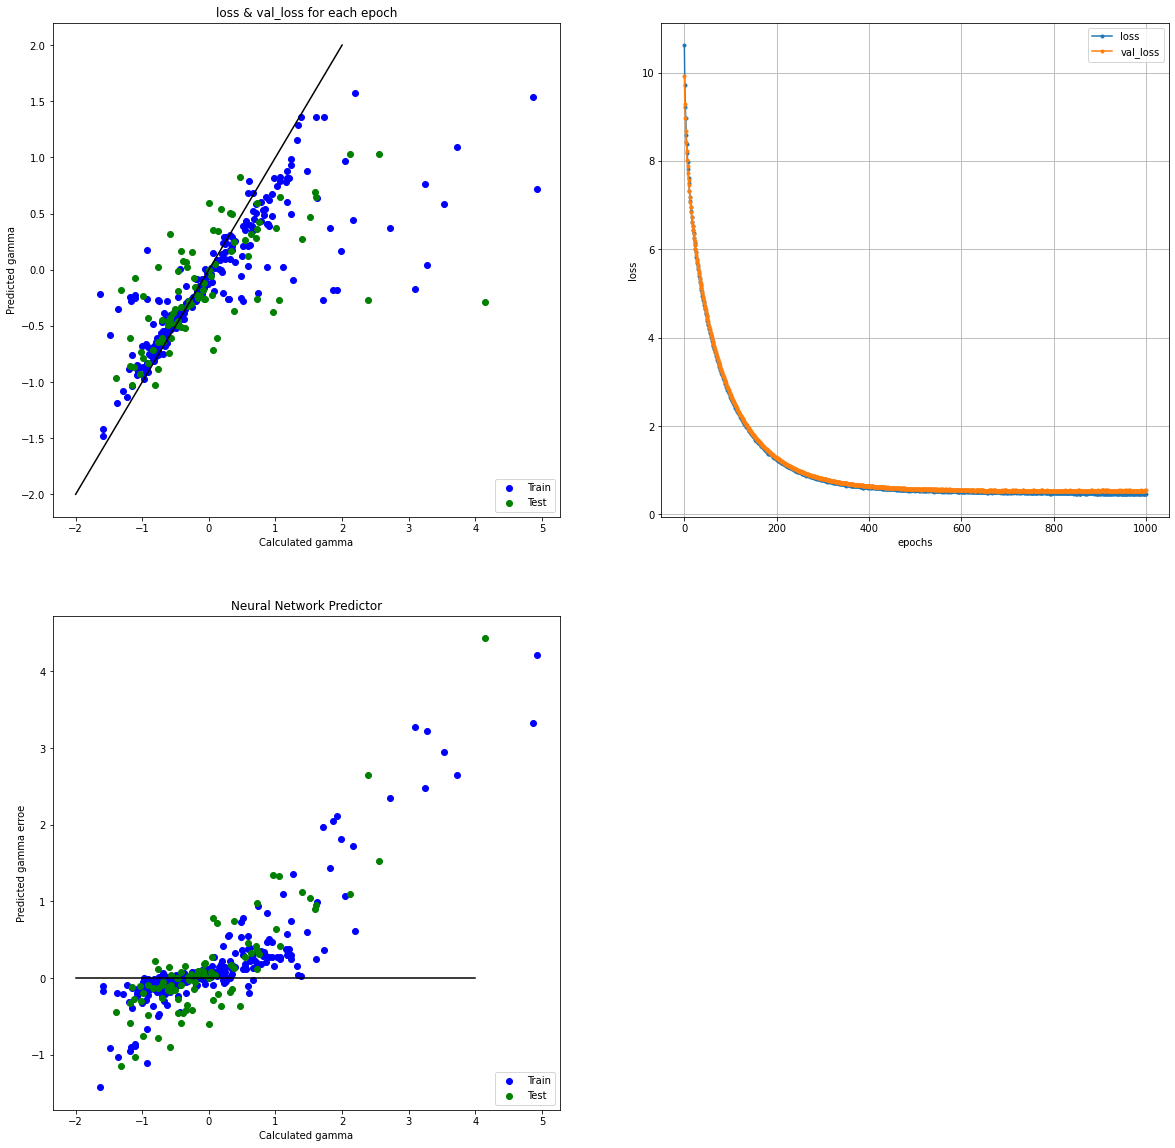

In [22]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(221)
ax1.set_title('Neural Network Predictor')
ax1.set_xlabel('Calculated gamma')
ax1.set_ylabel('Predicted gamma')
#ax1.set_xlim(0,1)
#ax1.set_ylim(0,1)
ax1.scatter(y_train, model.predict(X_train), label = 'Train', c = 'blue')
ax1.scatter(y_test, model.predict(X_test),c='green', label = 'Test', alpha = None)
ax1.plot([-2,2],[-2,2],c = 'k')
ax1.legend(loc = 4)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)

ax2 = fig.add_subplot(222)
ax1.set_title('loss & val_loss for each epoch')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
#ax2.set_ylim(0,0.2)
ax2.plot(range(epochs), loss, marker = '.', label = 'loss')
ax2.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
ax2.legend(loc = 'best')
ax2.grid()

ax3 = fig.add_subplot(223)
ax3.set_title('Neural Network Predictor')
ax3.set_xlabel('Calculated gamma')
ax3.set_ylabel('Predicted gamma erroe')
#ax1.set_xlim(0,1)
#ax1.set_ylim(0,1)
ax3.scatter(y_train,y_train-model.predict(X_train), label = 'Train', c = 'blue')
ax3.scatter(y_test,y_test-model.predict(X_test),c='green', label = 'Test', alpha = None)
ax3.plot([-2,4],[0,0],c = 'k')
ax3.legend(loc = 4)

plt.show()

In [17]:
engine = pyttsx3.init() 
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[2].id)
engine.say('Attention! Attention! Your job has been completed!')
engine.runAndWait()

## Conclusion

relu 的效果还不错